In [ ]:
!pip install textattack pyarrow==1.0 bert_score > /dev/null

ERROR: datascience 0.10.6 has requirement folium==0.2.1, but you'll have folium 0.8.3 which is incompatible.
ERROR: textattack 0.2.4 has requirement pyarrow<1.0, but you'll have pyarrow 1.0.0 which is incompatible.


In [ ]:
import nlp
dataset = nlp.load_dataset('snli')


Dataset snli downloaded and prepared to /root/.cache/huggingface/datasets/snli/plain_text/1.0.0/e417f6f2e16254938d977a17ed32f3998f5b23e4fcab0f6eb1d28784f23ea60d. Subsequent calls will reuse this data.


In [ ]:
from nltk.corpus import wordnet

import textattack
from textattack.transformations.word_swap import WordSwap


class WordSwapWordNetAntonym(WordSwap):
    """Transforms an input by replacing its words with synonyms provided by
    WordNet."""

    def _get_replacement_words(self, word, random=False):
        """Returns a list containing all possible words with 1 character
        replaced by a homoglyph."""
        antonyms = set()
        for syn in wordnet.synsets(word):
            for lemma in syn.lemmas():
                if lemma.antonyms():
                  for ant_lemma in lemma.antonyms():
                    ant_word = ant_lemma.name()
                    if (
                        (ant_word != word)
                        and ("_" not in ant_word)
                        and (textattack.shared.utils.is_one_word(ant_word))
                    ):
                        # WordNet can suggest phrases that are joined by '_' but we ignore phrases.
                        antonyms.add(ant_word)
        return list(antonyms)

textattack: First time running textattack: downloading remaining required packages.
textattack: Downloading NLTK required packages.


[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Unzipping corpora/wordnet.zip.
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /root/nltk_data...
[nltk_data]   Unzipping taggers/averaged_perceptron_tagger.zip.
[nltk_data] Downloading package universal_tagset to /root/nltk_data...
[nltk_data]   Unzipping taggers/universal_tagset.zip.
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


wandb: WARNING W&B installed but not logged in.  Run `wandb login` or set the WANDB_API_KEY env variable.


In [ ]:
import numpy as np
import random
import textattack
import tqdm

test_data_raw = dataset['test']
augmented_data = []

stopword_constraint = textattack.constraints.pre_transformation.StopwordModification()
gpt2_constraint = textattack.constraints.grammaticality.language_models.GPT2(max_log_prob_diff=3.0)
pct_words_to_swap_list = np.arange(0.1, 0.6, 0.1)

syn_transformation = textattack.transformations.WordSwapWordNet()
syn_augmenter = textattack.augmentation.Augmenter(syn_transformation, constraints=[stopword_constraint, gpt2_constraint], pct_words_to_swap=.25)

ant_transformation = WordSwapWordNetAntonym()
ant_augmenter = textattack.augmentation.Augmenter(ant_transformation, constraints=[stopword_constraint, gpt2_constraint], pct_words_to_swap=.25)

i = 0
all_augmentations = set()
while len(augmented_data) < 1000 * len(pct_words_to_swap_list) * 2:
  text = test_data_raw[i]['hypothesis']
  all_augmentations.add(text) # prevent identity augmentation

  for pct_words_to_swap in pct_words_to_swap_list:
    for augmenter in (syn_augmenter, ant_augmenter):
      augmenter.pct_words_to_swap = pct_words_to_swap
    syn_transformed_texts = syn_augmenter.augment(text)
    syn_transformed_texts = list(set(syn_transformed_texts) - all_augmentations)
    if syn_transformed_texts:
      augmentation = random.choice(syn_transformed_texts)
      all_augmentations.add(augmentation)
      syn_example = {
          'sentence1': text,
          'sentence2': augmentation,
          'label': 'synonym',
          'pct_words_to_swap': pct_words_to_swap,
      }
    else:
      # print(f'Warning: found no synonym transformations at i={i} for text={text}')
      i += 1
      continue

    ant_transformed_texts = ant_augmenter.augment(text)
    ant_transformed_texts = list(set(ant_transformed_texts) - all_augmentations)
    if ant_transformed_texts:
      augmentation = random.choice(ant_transformed_texts)
      all_augmentations.add(augmentation)
      ant_example = {
          'sentence1': text,
          'sentence2': augmentation,
          'label': 'antonym',
          'pct_words_to_swap': pct_words_to_swap,
      }
    else:
      # print(f'Warning: found no antonym transformations at i={i} for text={text}')
      i += 1
      continue
    
    augmented_data.append(syn_example)
    augmented_data.append(ant_example)
    i += 1

print(f'Got {len(augmented_data)} augmentations.')

Some weights of GPT2LMHeadModel were not initialized from the model checkpoint at gpt2 and are newly initialized: ['h.0.attn.masked_bias', 'h.1.attn.masked_bias', 'h.2.attn.masked_bias', 'h.3.attn.masked_bias', 'h.4.attn.masked_bias', 'h.5.attn.masked_bias', 'h.6.attn.masked_bias', 'h.7.attn.masked_bias', 'h.8.attn.masked_bias', 'h.9.attn.masked_bias', 'h.10.attn.masked_bias', 'h.11.attn.masked_bias', 'lm_head.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


IndexError: ignored

In [ ]:
from textattack.constraints.semantics.sentence_encoders import UniversalSentenceEncoder

constraint = UniversalSentenceEncoder()

import torch

def use_dist(s1, s2):
  emb1, emb2 = constraint.model([s1, s2])
  emb1, emb2 = torch.tensor(emb1.numpy()), torch.tensor(emb2.numpy())
  return torch.nn.CosineSimilarity(dim=0)(emb1, emb2).item()

print(use_dist('I love to eat chocolate', 'Chocolate is so good'))
print(use_dist('Turkey is a country, just like Chile', 'Alex Rodriguez takes steroids'))

Using /tmp/tfhub_modules to cache modules.
Downloaded https://tfhub.dev/google/universal-sentence-encoder/4, Total size: 987.47MB
Downloaded TF-Hub Module 'https://tfhub.dev/google/universal-sentence-encoder/4'.


0.7270164489746094
0.0411975122988224


In [ ]:
import bert_score
bert_scorer = bert_score.BERTScorer(
    model_type='bert-base-uncased', idf=False, device='cpu'
)

BERT_SCORE_TYPE2IDX = {"precision": 0, "recall": 1, "f1": 2}

def bert_score_dist(s1, s2):
  result = bert_scorer.score([s1], [s2])
  return result[BERT_SCORE_TYPE2IDX['f1']].item()


print(bert_score_dist('Are you having fun?', 'Are you fun having?'))
print(bert_score_dist('I love to eat chocolate', 'Chocolate is so good'))
print(bert_score_dist('Turkey is a country, just like Chile', 'Alex Rodriguez takes steroids'))


0.7307001948356628
0.5003132820129395
0.3376696705818176


In [ ]:
import tqdm

data_points = []
for j in tqdm.trange(0, len(augmented_data), leave=True, position=0):
  data_point = augmented_data[j]
  data_point['use_cos_sim'] = use_dist(data_point['sentence1'], data_point['sentence2'])
  data_point['bert_score'] = bert_score_dist(data_point['sentence1'], data_point['sentence2'])
  data_points.append(data_point)

100%|██████████| 10004/10004 [14:25<00:00, 11.55it/s]


In [ ]:
import pandas as pd

df = pd.DataFrame(data_points)

In [ ]:
df

,sentence1,sentence2,label,pct_words_to_swap,use_cos_sim,bert_score
0,The church has cracks in the ceiling.,The church has cracks in the roof.,synonym,0.1,0.868142,0.967121
1,The church has cracks in the ceiling.,The church has cracks in the ceiling.,antonym,0.1,1.000000,1.000000
2,The woman has been shot.,The woman has been tear.,synonym,0.1,0.687270,0.709627
3,The woman has been shot.,The man has been shot.,antonym,0.1,0.804613,0.954439
4,There is a statue that not many people seem to...,there is a statue that not many people seem to...,synonym,0.1,1.000000,1.000000
...,...,...,...,...,...,...
9999,The young man jumping against the wall is hisp...,The young civilian jumping against the wall is...,antonym,0.2,0.873400,0.950300
10000,The young man jumping against the wall is hisp...,The young mankind jumping against the wall is ...,synonym,0.3,0.885318,0.879457
10001,The young man jumping against the wall is hisp...,The old woman jumping against the wall is hisp...,antonym,0.3,0.830861,0.927497
10002,The young man jumping against the wall is hisp...,The young humanity jumping against the bulwark...,synonym,0.4,0.666963,0.757746


In [ ]:
import seaborn as sns
sns.set()

Text(0.5, 1.0, 'USE Cosine Similarity')

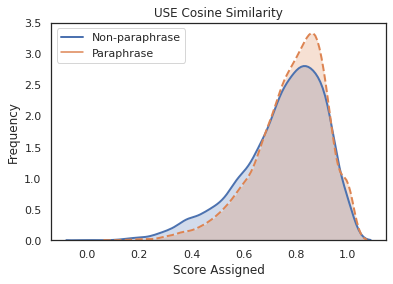

In [ ]:
sns.set_style("white")

ax = sns.kdeplot(df[df['label'] == 'synonym']['use_cos_sim'], label='Non-paraphrase', shade=True)#, color="#1f77b4")
# ax.lines[0].set_linestyle("dotted")
ax.lines[0].set_linewidth(2)
ax = sns.kdeplot(df[df['label'] == 'antonym']['use_cos_sim'], label='Paraphrase', shade=True)#, color="orange")
ax.lines[1].set_linestyle("dashed")
ax.lines[1].set_linewidth(2)

ax.set_xlabel('Score Assigned')
ax.set_ylabel('Frequency')

ax.set_title('USE Cosine Similarity')

In [ ]:
tax = sns.kdeplot(df[df['label'] == 'synonym']['bert_score'], label='Synonym', shade=True)
ax = sns.kdeplot(df[df['label'] == 'antonym']['bert_score'], label='Antonym', shade=True)

for line in ax.lines:
  line.set_linewidth(2)
ax.lines[1].set_linestyle('dashed')

ax.set_xlabel('Score Assigned')
ax.set_ylabel('Frequency')

ax.set_title('BERT Score')

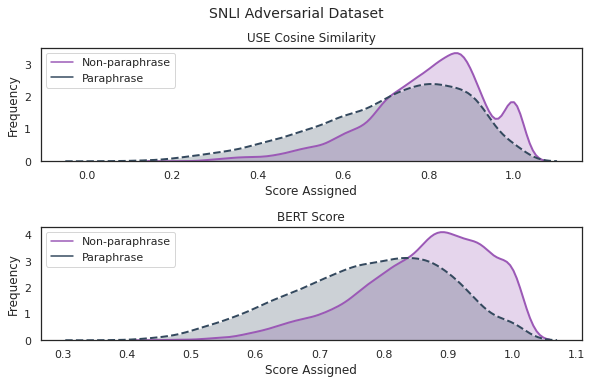

In [ ]:
import seaborn as sns
sns.set_style("white")

import matplotlib.pyplot as plt
fig, ax = plt.subplots(2)

#######################################
####   Graph 1 - USE Similarity    ####
#######################################
sns.kdeplot(df[df['label'] == 'antonym']['use_cos_sim'], label='Non-paraphrase', shade=True, ax=ax[0], color="#9b59b6")
sns.kdeplot(df[df['label'] == 'synonym']['use_cos_sim'], label='Paraphrase', shade=True, ax=ax[0], color="#34495e")
ax[0].lines[0].set_linewidth(2)
ax[0].lines[1].set_linewidth(2)
ax[0].lines[1].set_linestyle("dashed")

ax[0].set_xlabel('Score Assigned')
ax[0].set_ylabel('Frequency')
ax[0].set_title('USE Cosine Similarity')

#######################################
####   Graph 2 - BERT Score        ####
#######################################
sns.kdeplot(df[df['label'] == 'antonym']['bert_score'], label='Non-paraphrase', shade=True, ax=ax[1], color="#9b59b6")
sns.kdeplot(df[df['label'] == 'synonym']['bert_score'], label='Paraphrase', shade=True, ax=ax[1], color="#34495e")
ax[1].lines[0].set_linewidth(2)
ax[1].lines[1].set_linewidth(2)
ax[1].lines[1].set_linestyle('dashed')

ax[1].set_xlabel('Score Assigned')
ax[1].set_ylabel('Frequency')
ax[1].set_title('BERT Score')


fig_size = plt.gcf().get_size_inches()
sizefactor = 1.4 # Zoom factor
plt.gcf().set_size_inches(sizefactor * fig_size) 

fig.suptitle('SNLI Adversarial Dataset', fontsize=14)
fig.tight_layout(rect=[0, 0.03, 1, 0.95]) # Magic layout that takes into account subptitle
plt.savefig('snli_adversarial_constraint_distribution.pdf')

AUC for bert_score: 0.6338039953950447
AUC for use_cos_sim: 0.5449332062456904


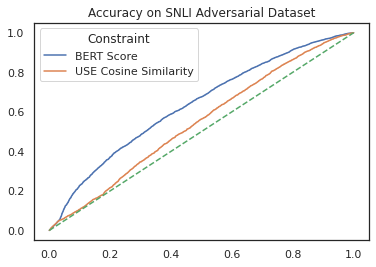

In [ ]:
import matplotlib.pyplot as plt

from sklearn.metrics import roc_curve, auc

fig, ax = plt.subplots()
def plot_roc(pred_key, ax=None, plot_reference_line=False):
  y = [(1.0 if x['label'] == 'antonym' else 0.0) for x in data_points]
  preds = [x[pred_key] for x in data_points]
  fake_preds = [0] * len(y) # fake predictions for linear roc curve
  fpr, tpr, thresholds = roc_curve(y, preds)
  print(f'AUC for {pred_key}:', auc(fpr, tpr))
  fake_fpr, fake_tpr, fake_thresholds = roc_curve(y, fake_preds)

  sns.lineplot(fpr, tpr, ax=ax)#, title='ROC Curve')

  if plot_reference_line:
    plt_ax = sns.lineplot(fake_fpr, fake_tpr, ax=ax)#, title='ROC Curve')
    plt_ax.lines[-1].set_linestyle('dashed')
  # sns.kdeplot(df[df['label'] == '1']['bert_score'], label='Paraphrase', shade=True, ax=ax[1])


plot_roc('bert_score', ax=ax)
plot_roc('use_cos_sim', ax=ax, plot_reference_line=True)

plt.legend(title='Constraint', loc='best', labels=['BERT Score', 'USE Cosine Similarity', ])
plt.title('Accuracy on SNLI Adversarial Dataset')
plt.savefig('snli_adversarial_roc.pdf')

In [ ]:
df

NameError: ignored

In [ ]:
use_dist('A man playing a piano A boy is playing trombone', 'A man playing a forte A girl is playing trombone.')

0.7866576910018921

In [ ]:
use_dist('Little boy peering into a glass display case. a girl is walking', 'Little boy peering into a glass display case. a boy is ride')

0.8171654939651489